# PyRoad, a Python module for extracting road geometric characteristics

 **Authors**:* Ekhine Irurozki, Kristina Stemikovskaya and Borja Calvo. *

Developed in Python3, dependencies:
- pandas
- numpy
- json


This notebook introduces PyRoad, a Python module for generating a data base of road segments and visualizing them in the map. These road segments result from partitioning the road in blocks which are homogeneous in the next three criteria: **curvature, intersection and tunnels**. This notebook document contains the Python code needed to run PyRoad. It is a self-contained tutorial whose code can be run as usual (by command-clicking the code cells). For information on how to install Jupyter and run a notebook visit http://jupyter-notebook.readthedocs.io/en/latest/. 

In this example, all the information is extracted from the Open Street map (OSM). Without this notebook trying to be a tutorial on OSM, we briefly take a note on how the roads are defined in OSM. Roads are collections of *ways*. A way is an ordered sequence of nodes and a node is a point in the earth -characterized by its longitude and latitude. A way in OSM has common properties such as name, type of way, number of lanes in the road, the existence of a sidewalk, etc. Departing from that data, we generate a set of segments. A segment is also an ordered sequence of points which are a contiguous part of a road. Moreover, they have **common geometric properties** (curvature, intersection and tunnels). Ways and segments are not necessarily the same. 

Summarizing, this tutorial shows how to use PyRoad to read road data from OSM and partiton the road into homogeneous segment. As a result, we will generate as output:
- an interactive map which can be opened with GIS programs such as Google Earth, 
- a table including every pair of adjacent segments in the roads and
- a table summarizing the characteristics of each segment in the roads including the following fields (i.e., features):
    - `seg_id`: segment identifier
    - `road_list`: list of road names of the ways in the segment
    - `road`: most common road name for the ways in the segment
    - `tunnel`: True iff the segment is in a tunnel
    - `curv_rad_avg`: the curvature radius (in meters) divided by the number of points in the segment
    - `count_lines`: number of points in this segment minus one
    - `curv_rad_min`: the minimum value of the radious of curvature in this segment
    - `length`: length in meters of the segment
    - `intersect`: True iff the segment is part of an intersection of two or more rows
    - `roundabout`: True iff the segment is part of a roundabout
    - `curv_adj_mean`: the mean of the 'curv_rad_avg' property of all the adjacent segments
    - `intersect_adj`: True if the 'intersect' property of any of the adjacent segments is True
    - `length_adj`: the sum of the length properties of all the adjacent segments
    - `curv_adj_min`: the minimum value of the radious of curvature among those segments adjacent to this one
    - `roundabout_adj`: True if the 'roundabout' property of any of the adjacent segments is True



To extend this code to include data coming from other sources such as the altitude or road capacity, each point in the road must be updated with the new information. 



In the following sections we will cover this steps:

1. We show how to download road specific data from Open Street map
2. Loading an existing map
3. Generating the segments of the road
4. Visualize the segments and segmenting criteria on a map. 


The required imports are the following

In [2]:
import RG_input_output as io
import RG_clean as cl
from timeit import default_timer as timer
from imp import reload
import pandas as pd
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

## Downloading the road data from Open Street map

This section shows how OSM data can be obtained. There are several alternatives for this step, including python modules such as `osmapi`. If you want to continue the example with any of the maps provided, jump to the next section, named *"Loading a map"*. Otherwise, continue reading this to see how to **download road data from OSM using Overpass Turbo (OT)**. 

OT is a tool for OSM which allows to zoom an area of the map, perform a query (such as "display all airports" or "show all roads in this area") and export the results. 


OSM stores stores a huge amount of information. Even if we focus on rows, there are multiple kinds, from pedestrian and living streets to motorways -for a detailed explanation of road types and labels in OSM see http://wiki.openstreetmap.org/wiki/Key:highway. In this example, we would restrict our search and look for a smaller set of road types, `R1  = ['motorway', 'trunk', 'primary','secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'primary_link', 'motorway_link', 'trunk_link'] `. 
Our interest in OT is because it provides a simple interface to extract these and only these roads from OSM, we just have use the following query:

`highway=motorway or highway=trunk or highway=primary or highway=secondary or highway=secondary_link or highway=tertiary or highway=tertiary_link or highway=primary_link or highway=motorway_link or highway=trunk_link`

Now, we show how to visualize and export the results of the query.

1. Open Overpass Turbo (https://overpass-turbo.eu) and focus on the area of interest. 
2. Click the wizard button on the top left menu. Write the query in the box, which in our case is: 
    >   `highway=tertiary or highway=tertiary_link or highway=trunk or highway=secondary or highway=primary_link or highway=secondary_link or highway=primary or highway=motorway or highway=trunk_link or highway=motorway_link`

3. Press the enter button to build and run the query. 
4. Click the Export button on the top left menu and download the result as "Raw data"


## Loading and preprocessing a map
The following commands load the map, detect the road intersections and calculate the curvature.


In [48]:
reload(cl)
reload(io)
#input_map = './Lapurdi.json'
input_map = './Roma.json'
#input_map = './New_York.json'
#input_map = './Malta.json'
#input_map = './Sao_Miguel.json'

start = timer()
print("Reading the map and processing the roads. This can take a few seconds.")
dfways, segments, dfcoord = io.read_road_data(input_map)
print("1/4. Loading the map. Elapsed time:", "{:.3f}".format(timer() - start),"s")
start = timer()
dfways, paths = cl.join_ways(dfways, segments)
print("2/4. Building paths. Elapsed time:", "{:.3f}".format(timer() - start),"s")
start = timer()
paths = cl.segments2coords(paths, dfcoord, dfways) 
print("3/4. Introducing coordinates. Elapsed time:", "{:.3f}".format(timer() - start),"s")
start = timer()
#cl.label_manually(dfways)#If any way in Open Stret Map is incorrectly labelled you can label it here.
paths = cl.set_junctions(dfways, paths)
print("4/4. Detecting intersections. Elapsed time:", "{:.3f}".format(timer() - start),"s")
max_lat, min_lat, max_lon, min_lon = max(dfcoord.lat), min(dfcoord.lat), max(dfcoord.lon), min(dfcoord.lon)

Reading the map and processing the roads. This can take a few seconds.
1/4. Loading the map. Elapsed time: 1.634 s
2/4. Building paths. Elapsed time: 1.475 s
3/4. Introducing coordinates. Elapsed time: 3.800 s
4/4. Detecting intersections. Elapsed time: 9.905 s


**Reducing the database**
It is usually the case that some road types (such as the links, for example) are useful to detect the intersections with more important roads but, besides from that, we do not need them. This means that after the intersections have been located, the smaller roads can be discarded. In our example, we focus only on 'motorway', 'trunk' and 'primary' roads, and discard every other road type. 


In [49]:
reload(cl)
reload(io)
R2 = ['motorway', 'trunk', 'primary']

paths = cl.check_last_line(paths)
dfways, paths = cl.select_roads(dfways, paths, R2)
cl.join_reduced_ways(paths)

Discarding ways: from 1211 to 193


**Curvature**
Once discarded the roads that we do not need, we join the remaining ways and calculate the curvature. 


The curvature is defined for every three adjacent points in a road as the radius of the circumference which touches the three points. The curvature is measured in meters. The maximum value of the curvature is set to 10000(\*).

The roads GPS coordinates are captured by a GPS device in a car driving along the roads and, due to some inaccuracies, do not exactly match the roads in every case. Sources of error may come from the driver changing the lane, device inaccuracy, large distance between points, etc. To improve the quality of the data, the curvature value is corrected by smoothing the lines describing the roads. 

(\*): These parameters are defind in the first lines of the file `RG_clean.py`.

In [50]:
reload(cl)
reload(io)
cl.curvature(paths) 

## Make homogeneous segments

Now that the road paths have been processed, it is time to partition the paths into homogeneous segments and label each of them, i.e., assign a segment id (`seg_id`) to each of them. The process is carried out as a series of segmentations as follows:

1. Detect and label each roundabout, which consists of the circular road and their adjacent 100 meters(\*) of the adjacent roads.
2. For every road section not yet labeled, detect and label each tunnel.
3. For every road section not yet labeled, detect and label each chunk of road in the intersection of rows.
4. For every road section not yet labeled, detect and label the sections of homogeneous curvature. In particular, the chunks with a curvature smaller than 600 meters(\*) will be differenciated of the road chunks with curvature greater than or equal to 600 meters(\*).

(\*): These parameters are defind in the first lines of the file `RG_clean.py`.

In [51]:
reload(cl)
reload(io)
contsegment = cl.segment_roundabouts(paths)
print("Roundabouts processed,", contsegment, "segments found")
contsegment = cl.segments_tunnels(paths,contsegment, dfways)
print("Tunnels processed,", contsegment, "segments found")
contsegment = cl.segment_weaving(paths,contsegment)
print("Intersections processed,", contsegment, "segments found")
paths,contsegment = cl.segment_curves(paths,contsegment)
print("Curves processed,", contsegment, "segments found")
dfpaths = pd.concat(paths).reset_index(drop=True)
dfseg, dfseg_adj = cl.segment_summarize(dfpaths) 

Roundabouts processed, 5 segments found
Tunnels processed, 23 segments found
Intersections processed, 75 segments found
Curves processed, 105 segments found


## Resulting database

With two tables we summarie the information of the detected segments. In the first one, `dfseg`, the characteriztics of the segments. The second one, `dfseg_adj`, summarizes the adjacency relation between segments. In the following cells you can see the first 5 lines of each of them and afterwards you can export them to a `csv` file.

In [55]:
dfseg.head()

seg_id  count_lines  curv_rad_min  curv_rad_avg      length road_list  \
0     0.0            1  10000.000000  10000.000000    7.734848    (nan,)   
1     1.0            5     10.419278     19.958044   31.216390    (nan,)   
2     2.0            3     14.344873     14.646846  112.879818    (nan,)   
3     3.0            2     15.210739     15.210739   12.502394    (nan,)   
4     4.0            3     13.965625     14.862222  105.138617    (nan,)   

   road_count  road tunnel intersect roundabout roundabout_adj   length_adj  \
0           1   NaN  False      True       True           True   999.306274   
1           1   NaN  False      True       True           True   684.176507   
2           1   NaN  False      True       True           True   369.709557   
3           1   NaN  False      True       True           True  1479.410797   
4           1   NaN  False      True       True           True   461.702906   

   curv_adj_mean  curv_adj_min intersect_adj  
0    1323.988635     13.965625          True  
1    1652.756172     14.344873          True  
2     888.571393     10.419278          True  
3    4722.565480     10.419278          True  
4    4148.073460     14.344873          True

In [53]:
dfseg_adj.head()

seg_id_x  seg_id_y
1      23.0      35.0
2      23.0      76.0
3      35.0      23.0
5      35.0      76.0
6      76.0      23.0

In [16]:
dfseg.to_csv('./my_dfseg.csv')
dfseg_adj.to_csv('./my_dfseg_adj.csv')

## Visualize the result on a map
This command generates a .kml map which can be open with several applications such as Google Earth. 

In [54]:
reload(io)
outpath = './processed_map.kml'
io.write(outpath,paths, max_lat, min_lat, max_lon, min_lon, dfseg)

The following images are captures of a map generated with this notebook.

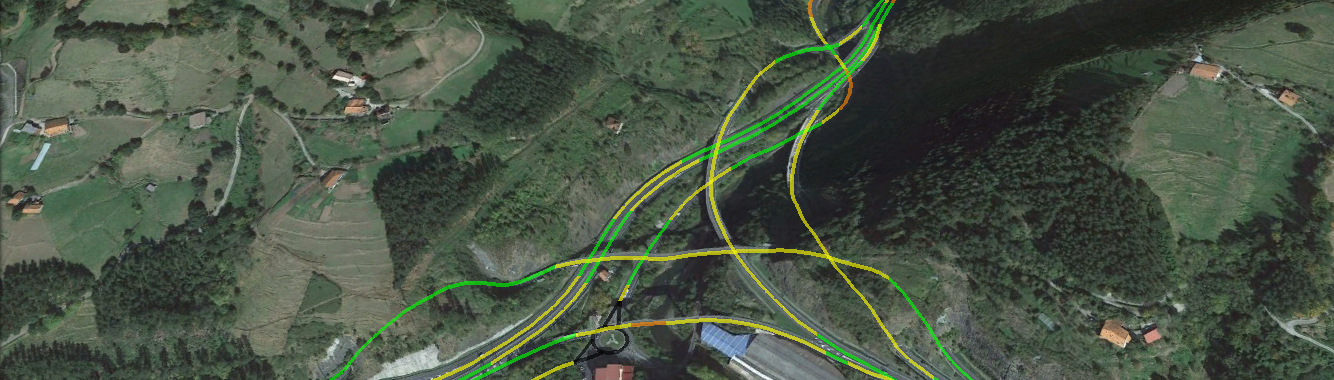

In [57]:
from IPython.display import Image
Image(filename='img/curve.png')

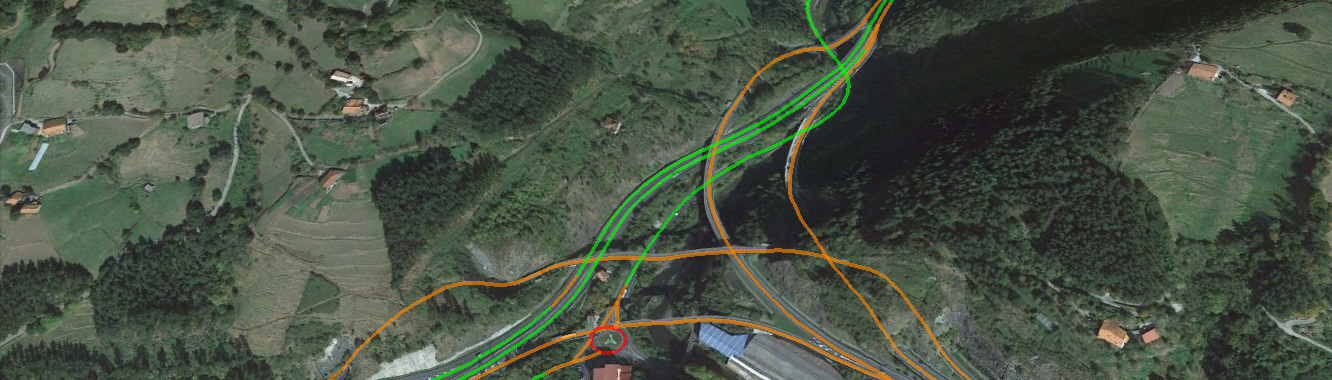

In [58]:
Image(filename='img/junct.png')

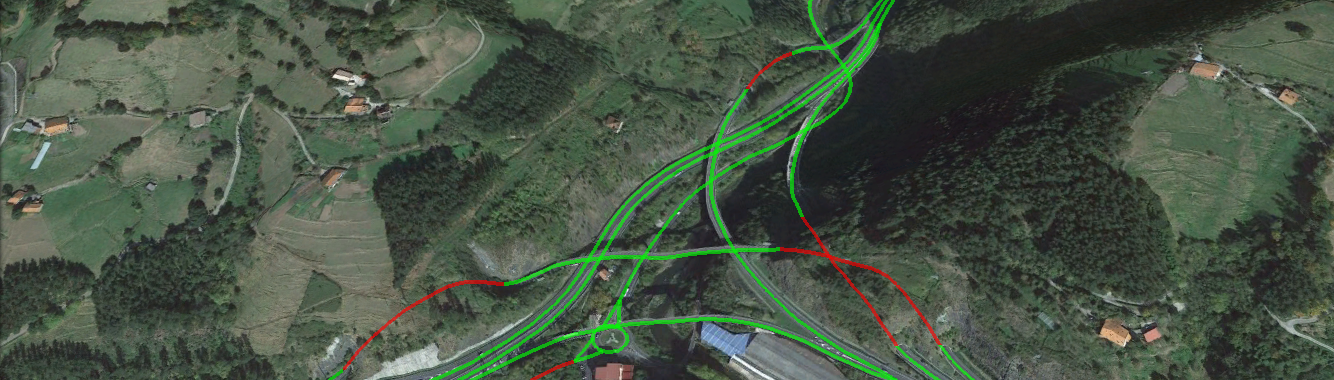

In [59]:
Image(filename='img/tunnel.png')

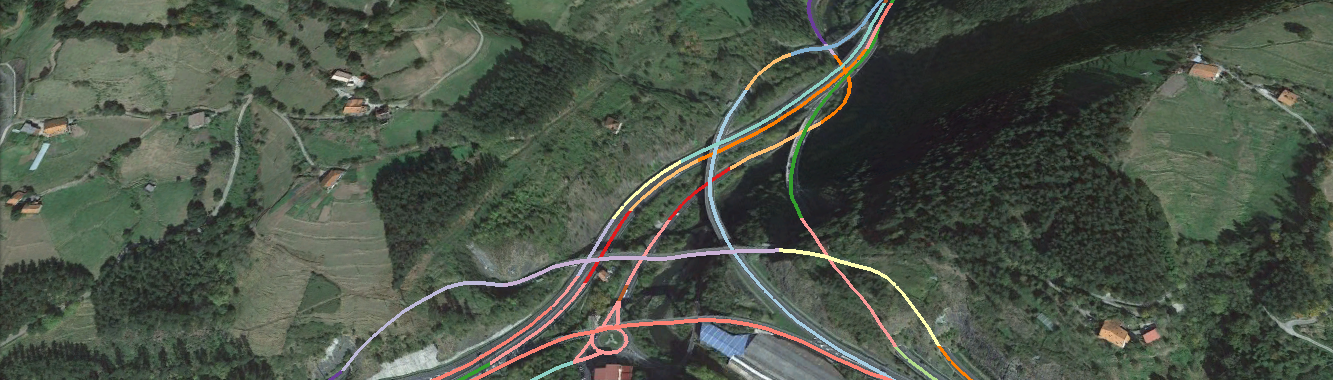

In [60]:
Image(filename='img/segments.png')

We have included data coming from other sources and represent it here on the map. This data is the volume of daily traffic and the speed limit. 

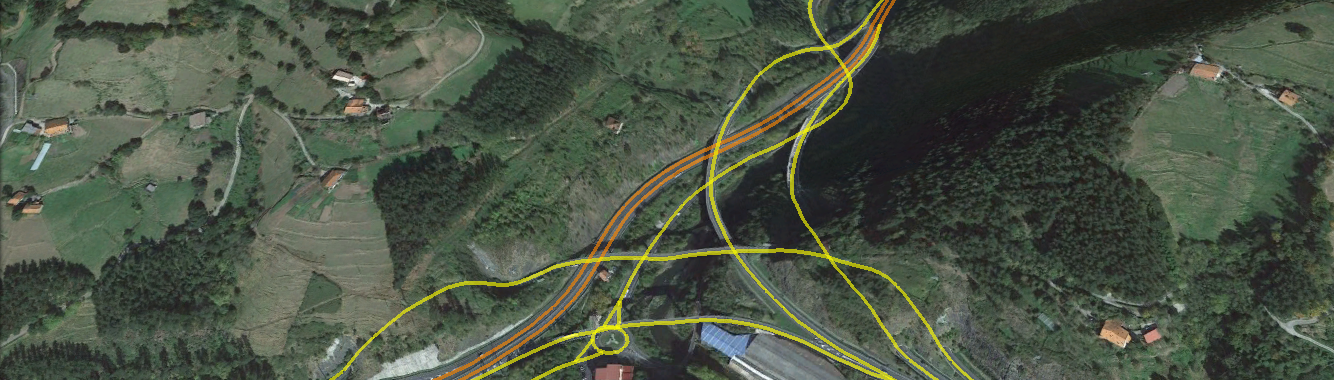

In [61]:
Image(filename='img/imd.png')

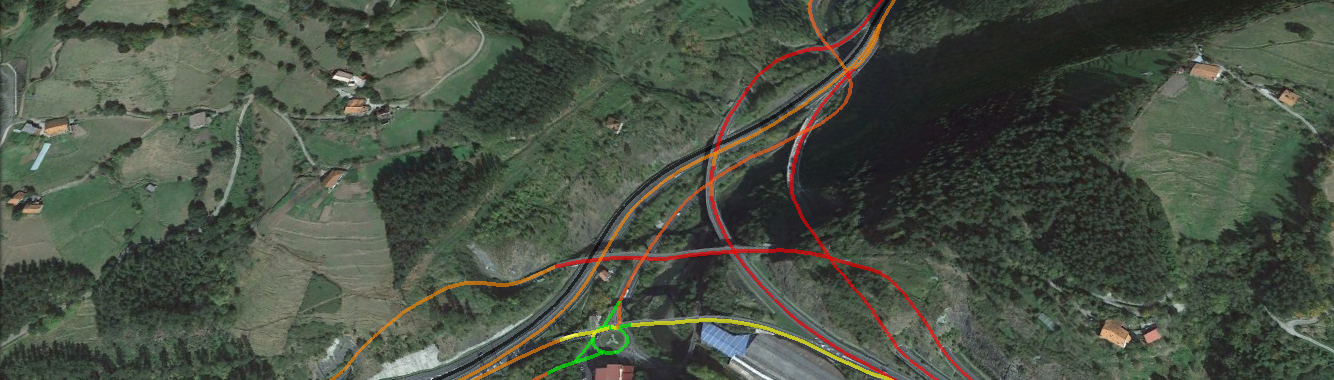

In [62]:
Image(filename='img/speed.png')